In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from generation.dataset.data_utils import get_detector_signals

In [9]:
def get_shapes_correlation(detector1, detector2, eps=1e-20):  
    def unify_shape(data):
        min_values = np.min(data, axis=1)
        max_values = np.max(data, axis=1)
        data = (data - min_values[:, None]) / (max_values - min_values + eps)[:, None]
        return data

    signals1 = unify_shape(get_detector_signals(detector1))
    signals2 = unify_shape(get_detector_signals(detector2))
    
    corrs = []
    assert len(signals1) == len(signals2)
    for idx in range(len(signals2)):
        corrs.append(np.corrcoef(signals1[idx] + eps, signals2[idx] + eps)[0, 1])
    corrs = np.array(corrs).flatten()
    return np.mean(corrs)


def get_amplitudes_correlation(detector1, detector2):
    signals1 = get_detector_signals(detector1)
    signals2 = get_detector_signals(detector2)
    
    amplitudes1 = np.max(signals1, axis=1) / np.max(signals1)
    amplitudes2 = np.max(signals2, axis=1) / np.max(signals2)
    
    return np.corrcoef(amplitudes1, amplitudes2)[0, 1]

In [10]:
DETECTORS_NUM = 9

amplitudes_corrs = np.zeros((DETECTORS_NUM, DETECTORS_NUM))
shapes_corrs = np.zeros((DETECTORS_NUM, DETECTORS_NUM))

for det1 in tqdm.tqdm(range(DETECTORS_NUM)):
    for det2 in range(DETECTORS_NUM):
        shapes_corrs[det1][det2] = get_shapes_correlation(det1, det2)
        amplitudes_corrs[det1][det2] = get_amplitudes_correlation(det1, det2)

100%|██████████| 9/9 [00:17<00:00,  1.98s/it]


In [11]:
np.round(shapes_corrs, 1)

array([[1. , 0.7, 0.6, 0.7, 0.6, 0.7, 0.6, 0.7, 0.6],
       [0.7, 1. , 0.7, 0.8, 0.8, 0.8, 0.7, 0.8, 0.7],
       [0.6, 0.7, 1. , 0.6, 0.6, 0.7, 0.6, 0.6, 0.6],
       [0.7, 0.8, 0.6, 1. , 0.9, 0.9, 0.7, 0.8, 0.6],
       [0.6, 0.8, 0.6, 0.9, 1. , 0.8, 0.6, 0.8, 0.6],
       [0.7, 0.8, 0.7, 0.9, 0.8, 1. , 0.7, 0.8, 0.7],
       [0.6, 0.7, 0.6, 0.7, 0.6, 0.7, 1. , 0.7, 0.6],
       [0.7, 0.8, 0.6, 0.8, 0.8, 0.8, 0.7, 1. , 0.7],
       [0.6, 0.7, 0.6, 0.6, 0.6, 0.7, 0.6, 0.7, 1. ]])

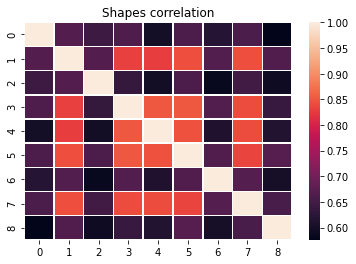

In [12]:
import seaborn as sns

plt.title("Shapes correlation")
sns.heatmap(shapes_corrs, linewidth=0.5)
plt.show()

In [13]:
np.round(amplitudes_corrs, 1)

array([[1. , 0.2, 0.1, 0.3, 0.3, 0.1, 0.2, 0.1, 0.1],
       [0.2, 1. , 0.2, 0.2, 0.4, 0.2, 0.2, 0.3, 0.2],
       [0.1, 0.2, 1. , 0.2, 0.3, 0.1, 0.1, 0.2, 0.1],
       [0.3, 0.2, 0.2, 1. , 0.3, 0.2, 0.2, 0.2, 0.1],
       [0.3, 0.4, 0.3, 0.3, 1. , 0.4, 0.2, 0.4, 0.3],
       [0.1, 0.2, 0.1, 0.2, 0.4, 1. , 0.1, 0.2, 0.3],
       [0.2, 0.2, 0.1, 0.2, 0.2, 0.1, 1. , 0.2, 0.2],
       [0.1, 0.3, 0.2, 0.2, 0.4, 0.2, 0.2, 1. , 0.1],
       [0.1, 0.2, 0.1, 0.1, 0.3, 0.3, 0.2, 0.1, 1. ]])

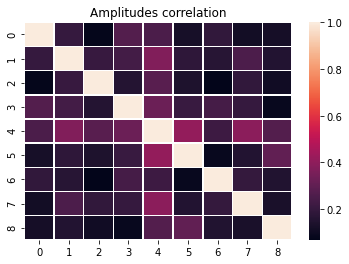

In [14]:
import seaborn as sns

plt.title("Amplitudes correlation")
sns.heatmap(amplitudes_corrs, linewidth=0.5)
plt.show()